In [ ]:
import networkx as nx
import pandas as pd

In [110]:
import numpy as np
from random import random

In [200]:
class Tournament(object):
    def __init__(self):
        # team Data
        self.team_dict = {}
        # Completed fixture Data
        self.fixture_list = []
        # Pending fixture Data
        self.pending_fixture_list = []
        # Default seed
        self.max_seed = 0
        # Points for a win
        self.win_pts = 3
        #Points for a draw
        self.draw_pts = 1
        #Points for a bye
        self.bye_pts = 3
    
    def add_team(self, name, seed = 'none', points = 0, more = {}):
        if seed == 'none':
            seed = self.max_seed
        
        self.team_dict[name] = {'seed': seed,
                                 'points': points,
                                 'opponents': [],
                                 'byes': 0}
        
        self.team_dict[name].update(more)
    
    def create_fixtures(self):
        teams_df = pd.DataFrame(self.team_dict).transpose().sample(frac = 1).sort_values(by = ['points','seed'], ascending = [False,True]).reset_index(names = 'name')
        # Check whether a team needs to be given a bye
        byeNeeded = (len(teams_df) % 2 == 1)
        
        # Create a network graph
        G = nx.Graph()
        
        # Add edges for each pairing of teams
        for row1 in teams_df.iterrows():
            idx = row1[0]
            data1 = row1[1]

            for row2 in teams_df[idx + 1: idx + 101].iterrows():
                data2 = row2[1]
                
                # requirement: don't pair teams who have already faced each other 
                if data2['name'] not in data1['opponents']:
                    ptsGap = abs(data1['points'] - data2['points'])
                    seedGap = abs(data1['seed'] - data2['seed'])
                    
                    # weights are determined by points gap and seed gap
                    weight = ptsGap - seedGap/1000
                    G.add_edge(data1['name'], data2['name'], weight = weight)
            
            # Calculate bye weights if necessary
            if byeNeeded & (len(teams_df) - idx < 101):
                pts = data1['points']
                seed = data1['seed']
                byes = data1['byes']

                weight = byes*1000 + pts - seed/1000
                G.add_edge(data1['name'],'bye', weight = weight)

        # Conduct minumum weight matching
        fixtures = nx.algorithms.matching.min_weight_matching(G)
        
        # Add opponent to each team, and bye count for the team with a bye
        for fixture in fixtures:
            if 'bye' in fixture:
                for team in fixture:
                    if team != 'bye':
                        self.team_dict[team]['byes'] += 1
                        self.team_dict[team]['points'] += self.bye_pts
            else:
                team1, team2 = fixture[0], fixture[1]
                self.team_dict[team1]['opponents'].append(team2)
                self.team_dict[team2]['opponents'].append(team1)
                self.pending_fixture_list.append(fixture)
    
    def report_result(self, result, more = {}):
        # Result format: {team1: score1, team2: score2}
        
        teams = list(result.keys())
        totals = list(result.values())
        
        # Remove entry in pending fixture list
        for fixture in self.pending_fixture_list:
            if (teams[0] in fixture) & (teams[1] in fixture):
                self.pending_fixture_list.remove(fixture)
        
        # Interpret result and add points
        if totals[0] > totals[1]:
            res =  teams[0]
            self.team_dict[teams[0]]['points'] += self.win_pts
        elif totals[0] == totals[1]:
            res = 'draw'
            for team in teams:
                self.team_dict[team]['points'] += self.draw_pts
        else:
            res = teams[1]
            self.team_dict[teams[1]]['points'] += self.win_pts
        
        # Store fixture result in fixture list
        # Result format: {'Home': team1, 'score1': score1, 'score2': score2, 'Away': team2, 'Result': winning team/draw}
        result_dict = {'Home': teams[0], 'score1': totals[0], 'score2': totals[1], 'Away': teams[1], 'Result': res}
        result_dict.update(more)
        self.fixture_list.append(result_dict)
        
    def fixtures_df(self):
        df = pd.DataFrame(self.fixture_list)
        return df

In [183]:
mymodel = np.poly1d([-0.63338287,  0.4410632 ,  0.08619369,  0.16459536])

In [204]:
def sim_fixtures(tournament):
    results = []

    for fixture in tournament.pending_fixture_list:
        team1, team2 = fixture[0], fixture[1]
        data1, data2 = tournament.team_dict[team1], tournament.team_dict[team2]
        elo1, elo2 = data1['elo'], data2['elo']

        score = sim_match(elo1, elo2)

        results.append({team1: score[0], team2: score[1]})
    
    return results

In [205]:
def sim_match(elo1, elo2):
    m = elo1 - elo2
    prob = 1/(1+10**(-m/400))

    draw_prob = mymodel(prob)
    win_prob = prob/(1-draw_prob)

    result = random()

    if win_prob - result > 0.00001:
        score = [1, 0]
    elif win_prob + draw_prob - result > 0.00001:
        score = [0.5, 0.5]
    else:
        score = [0, 1]
    
    return score

In [2]:
teams_data = pd.read_csv('teams_data.csv')

In [3]:
teams_data

,Club,Elo
0,1 Man City,2047
1,2 Real Madrid,1972
2,3 Liverpool,1957
3,4 Bayern,1952
4,5 Inter,1945
...,...,...
626,FCB Magpies,860
627,Atletic Club Escaldes,846
628,Cosmos,697
629,Tre Penne,686


In [209]:
to = Tournament()

In [210]:
for row in teams_data.iterrows():
    team = row[1].Club
    elo = row[1].Elo
    seed = row[0] + 1
    
    to.add_player(team, seed, more = {'elo': elo})

In [211]:
# Tournament simulator
season_length = 20

for n in range(1, season_length + 1):
    to.create_fixtures()

    results = sim_fixtures(to)

    for result in results:
        to.report_result(result, more = {'matchday': n})
    
    print(n)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [226]:
playersDF = pd.DataFrame(to.player_dict).transpose().sample(frac = 1).sort_values(by = ['points','seed'], ascending = [False,True]).reset_index(names = 'name')
playersDF[:50]

,name,seed,points,opponents,byes,elo
0,1 Man City,1,53,"[19 Newcastle, Hartberg, Angers, Espanyol, She...",0,2047
1,2 Real Madrid,2,44,"[Bochum, Pendikspor, Kortrijk, 87 Udinese, 54 ...",0,1972
2,7 Paris SG,7,44,"[Young Boys, Sivasspor, Degerfors, 86 Mallorca...",0,1875
3,8 Atlético,8,44,"[99 Montpellier, Viitorul, Caen, Debrecen, Met...",0,1872
4,3 Liverpool,3,43,"[Antwerp, Оренбург, Brommapojkarna, Динамо Киї...",0,1957
5,10 Dortmund,10,43,"[Heidenheim, Со́чи, Олександрія, St. Patrick's...",0,1856
6,17 Real Sociedad,17,43,"[ΠΑΟΚ, Casa Pia, בית""ר, 88 Strasbourg, Sparta ...",0,1814
7,6 Arsenal,6,42,"[Augsburg, 93 Luton, Bristol City, Magdeburg, ...",0,1920
8,9 Leverkusen,9,42,"[Bodø/Glimt, 82 Rayo Vallecano, Ceské Budejovi...",0,1863
9,16 PSV,16,42,"[Frosinone, Cosenza, Milsami, Sheffield Weds, ...",0,1814


In [249]:
fixture_df = to.fixtures_df()
team = playersDF.name[0]
print(to.player_dict[team])
fixture_df[(fixture_df.Home == team) | (fixture_df.Away == team)]

{'seed': 1, 'points': 53, 'opponents': ['19 Newcastle', 'Hartberg', 'Angers', 'Espanyol', 'Sheffield United', '14 Milan', '15 Aston Villa', '18 Napoli', '9 Leverkusen', '3 Liverpool', '86 Mallorca', '4 Bayern', '5 Inter', '7 Paris SG', '2 Real Madrid', '12 Juventus', '26 Man United', '24 Brighton', '11 Barcelona', '6 Arsenal'], 'byes': 0, 'elo': 2047}


,Home,score1,score2,Away,Result,matchday
291,1 Man City,1.0,0.0,19 Newcastle,1 Man City,1
469,1 Man City,1.0,0.0,Hartberg,1 Man City,2
930,1 Man City,1.0,0.0,Angers,1 Man City,3
1095,1 Man City,1.0,0.0,Espanyol,1 Man City,4
1367,1 Man City,1.0,0.0,Sheffield United,1 Man City,5
1757,1 Man City,1.0,0.0,14 Milan,1 Man City,6
2200,1 Man City,1.0,0.0,15 Aston Villa,1 Man City,7
2502,18 Napoli,0.0,1.0,1 Man City,1 Man City,8
2677,1 Man City,1.0,0.0,9 Leverkusen,1 Man City,9
2941,3 Liverpool,1.0,0.0,1 Man City,3 Liverpool,10


In [248]:
playersDF[playersDF.byes > 0]

,name,seed,points,opponents,byes,elo
216,Dinamo București,570,31,"[Craiova 1948, ΑΠΟΕΛ, Burgos, Sandefjord, Pard...",1,1142
480,Breiðablik,536,24,"[Göteborg, Bari, West Brom, Zagłębie, Дынама М...",1,1202
517,Haka,532,23,"[Cosmos, Bordeaux, 93 Luton, Астана, Hammarby,...",1,1208
563,Zeleznicar Pancevo,613,21,"[LKS, Basel, Lausanne, Nürnberg, Sheriff, Duna...",1,1035
597,FC Infonet,617,19,"[Iasi, Valenciennes, Amiens, Lok Zagreb, HJK H...",1,1001
607,Makedonija,598,18,"[FCB Magpies, Livingston, 33 Lens, Sampdoria, ...",1,1079
609,College Europa,624,18,"[Honka Espoo, Häcken, Zilina, Ордабасы, Славия...",1,907
615,Kruševac,602,17,"[LNZ, Alcorcon, בני סכנין, Wehen, Teplice, Ban...",1,1075
617,HB Tórshavn,611,17,"[Halmstad, Sochaux, Rostock, Varazdin, AIK, Wi...",1,1052
618,Atletic Club Escaldes,628,17,"[Niš, Hearts, Aris Limassol, Stal Mielec, Kalm...",1,846


<Axes: xlabel='name'>

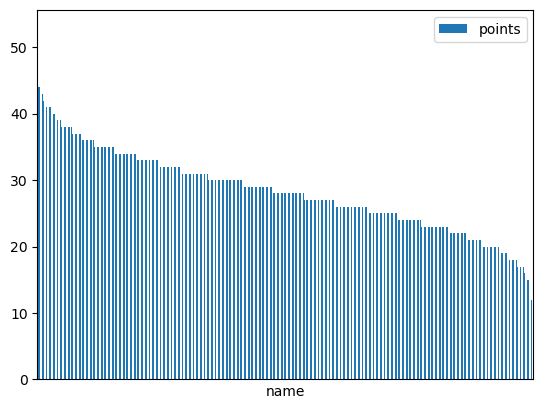

In [240]:
playersDF.plot.bar(x = 'name', y = 'points', xticks = [])